# Loading model

In [1]:
import torch
from qwerty_qwen2_update import QwertyQwen2ForCausalLM
from transformers import Qwen2ForCausalLM, Qwen2Tokenizer, CLIPImageProcessor, Trainer
from typing import Dict, Sequence
import os
import conversation 
from PIL import Image

device = 'cuda:2'
model_name_or_path: str = "/data/uchiha_ssd2/fengqi/241121_qwerty/251124_230127/"
vision_tower_name_or_path: str = "openai/clip-vit-large-patch14-336"

model = QwertyQwen2ForCausalLM.from_pretrained(
    model_name_or_path,
    torch_dtype=torch.bfloat16,
    )
model.to(device)
model.config.use_cache = True
tokenizer = Qwen2Tokenizer.from_pretrained(model_name_or_path)
image_processor = CLIPImageProcessor.from_pretrained(vision_tower_name_or_path)

Loading checkpoint shards:   0%|          | 0/7 [00:00<?, ?it/s]

# Loading weights

In [2]:
from safetensors import safe_open
folder_path = model_name_or_path
merged_weights: Dict[str, torch.Tensor] = {}
safetensors_files = [
    f for f in os.listdir(folder_path) 
    if f.endswith('.safetensors')
]

for file_name in safetensors_files:
    file_path = os.path.join(folder_path, file_name)
    with safe_open(file_path, framework="pt", device="cpu") as f:
        keys = f.keys()
        
        for key in keys:
            if key in merged_weights:
                print(f"警告: 键 {key} 在多个文件中出现,将使用文件 {file_name} 中的值")
            tensor = f.get_tensor(key)
            merged_weights[key] = tensor

for key in model.state_dict().keys():
    if key.startswith('vision_model'):
        print(key)
        assert model.state_dict()[key].shape == merged_weights['model.' + key].shape, "未能正确加载模型参数"
        model.load_state_dict({
            **model.state_dict(),
            **{key: merged_weights['model.' + key] for key in merged_weights}
        }, strict=False)
        #model.state_dict()[key] = merged_weights['model.' + key] 据说，直接修改 state_dict() 中的值通常是不被推荐的操作，因为 state_dict() 是一个浅拷贝，而不是模型参数的直接映射。这种操作可能会导致模型参数与优化器不匹配。
    if key.startswith('mm_projector'):
        print(key)
        assert model.state_dict()[key].shape == merged_weights['model.' + key].shape, "未能正确加载模型参数"
        model.load_state_dict({
            **model.state_dict(),
            **{key: merged_weights['model.' + key] for key in merged_weights}
        }, strict=False)
        
missing_keys, unexpected_keys = model.load_state_dict({
    **model.state_dict(),
    **{key: merged_weights[key] for key in merged_weights}
}, strict=False)
print(f"Missing keys: {missing_keys}")
print(f"Unexpected keys: {unexpected_keys}")

Missing keys: []
Unexpected keys: []


In [3]:
def response(image_path:str,prompt :str) -> None:
    cur_conv = conversation.conv_qwen2_5.copy()
    cur_image = Image.open(image_path)
    image = image_processor(cur_image, return_tensors='pt')['pixel_values']
    cur_conv.append_message(['USER',(prompt,cur_image)])
    text = cur_conv.get_prompt()
    text += "\n<|im_start|>assistant\n"
    input_ids = tokenizer(text,return_tensors="pt",add_special_tokens=False)['input_ids'][0]
    input_ids = input_ids.unsqueeze(0)
    attention_mask = torch.ones_like(input_ids)
    labels = torch.arange(input_ids.shape[-1]).unsqueeze(0)

    image = image.to(device)
    input_ids = input_ids.to(device)
    attention_mask = attention_mask.to(device)
    labels = labels.to(device)
    output_ids = model.generate(
        inputs=input_ids,                  # 输入 tokens
        max_length=1024,                      
        num_return_sequences=1,             # 返回生成的序列数
        temperature=0.7,                    # 控制生成的多样性
        top_k=50,                           # 限制最高概率的 K 个标记
        top_p=0.95,                         # 过滤累积概率小于 P 的标记
        do_sample=True,                     # 使用采样生成（而非贪心算法）
        images=image,
        attention_mask=attention_mask,
        labels=labels,
        use_cache=True,
    )
    generated_text = tokenizer.decode(output_ids[0], skip_special_tokens=True)
    print(f"Generated text:\n\n{generated_text}")

# Image 7

In [4]:
image_path:str = "test_images/7.M.jpg"

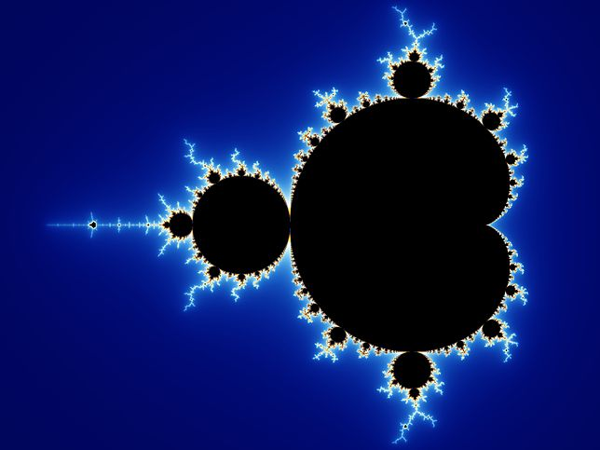

In [5]:
image = Image.open(image_path)
image2 = image.resize((600,int(600*image.height/image.width)))
image2

In [6]:
prompt :str = "<image>\nDescribe this picture concisely."

In [7]:
response(image_path,prompt)

Generated text:

The image displays a complex patterns of interconnected circles with a series of light and dark and dark and intricate shapes and swirling electric patterns can be seen on a dark shapes, swirling blue images can be seen against can be observed against can be formed in darkness can be found throughout can form electric patterns et forms be created within a intricate designs can form can form can be described as a be formed in a patterns are an intricate images and intricate pattern, can be observed in a intricate can be formed in a can be observed, can be observed, can be viewed, resembling blue be made against the be formed in this be created within a set against a elaborate designs in blue in this be formed as a brighted, can be described as the be formed in the be described as the be a be described as an image as the set against the form can be generated can be formed as a black in blue can be described as a picture in another can be generated, set within a, that lig

In [8]:
prompt :str = "<image>\nThis image is actually related to a mathematical concept. Do you know which one?"

In [9]:
response(image_path,prompt)

Generated text:

The image displays a representation in question is related to a visualizing the concept of a Droste, which shows the mathematical set of the "user user of a fascinating user

The image of the Drodruser
Thisuser
The image is associated the Drosteuser
Thisuser
The image illustratesuser
A(user of the Drosteuser
The image the Drosteuser
This description of the Droste
The image shows apattern
The image is an example
The image displaysThe image portrays the Droste
The image presents a picture of the Drosteff
This of the Drosteffuser of the Drosteffuser the Drosteffuser the Drosteffusion
The Drosteff
The Drosteffle the Drosteff
The Drosteff
The Drostefficientffle
The Drosteff
The Drosteff
The Drosteff
The Drosteff
The Drosteffsteff
The Drosteff
The Drostefficientff the Drosteff
steffle the Drosteffsteffsteffsteff
The Drosteff the Droff image illustratesff the Drosteffsteff
The Drosteff the Drosteffsteffsteffsteff the Drosteffleffsteffsteffsteff imageffsteff the Drosteffsteffs